# Daily Total Female Births

In [2]:
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
%matplotlib inline  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Python
import pandas as pd
import numpy as np
import datetime
from prophet import Prophet
from math import sqrt

#
from warnings import catch_warnings
from warnings import filterwarnings

# La librería statsmodel tiene implementaciones de SARIMA y de Holt-Winters
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Si el computador tiene procesadores múltiples, se aprovecharán
#from multiprocessing import cpu_count

from multiprocess import cpu_count
from joblib import Parallel

from joblib import delayed

c:\Users\Alien Ware\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [4]:
def parse_date (x): 
    return datetime.datetime.strptime("0"+str(x), '%y-%m') 

In [5]:
def division_entreno_prueba(datos, n_prueba):
    return datos[:-n_prueba], datos[-n_prueba:]

In [6]:
def medir_rmse(actual, predicho):
    return sqrt(mean_squared_error(actual, predicho))

In [7]:
def busqueda_malla(datos, lista_cfg, n_prueba, metodo = "sarima", paralelo = True):
    resultados = None
    if paralelo:
        # ejecutar las configuraciones en paralelo
        executor = Parallel(n_jobs = cpu_count(), backend = 'multiprocessing') 
        tareas = (delayed(calificar_modelo)(datos, n_prueba, metodo, cfg) for cfg in lista_cfg)
        resultados = executor(tareas)

    else:
        resultados = [calificar_modelo(datos, n_prueba, metodo, cfg) for cfg in lista_cfg]
    # eliminar resultados vacíos
    resultados = [r for r in resultados if r[1] != None]
    return resultados

In [8]:
def calificar_modelo(datos, n_prueba, metodo, cfg, debug = False):
    resultado = None
    predicciones = None
    # convertir la confiuración a una llave
    llave = str(cfg)
    if debug:
        resultado, predicciones = validacion_al_frente(datos, n_prueba, metodo, cfg)
    else:
        # una falla durante la validación del modelo sugiere una configuración inestable
        try:
        # nunca mostrar advertencias cuando se busca en malla...demasiado "ruido"
            with catch_warnings():
                filterwarnings("ignore")
                resultado, predicciones = validacion_al_frente(datos, n_prueba, metodo, cfg)
        except:
            error = None
    if resultado is not None:
        print(f' > Modelo{llave} {resultado:.3f}')
    return (llave, resultado, predicciones)

In [9]:
def config_simple(long_max, offsets = [1]):
    configs = []
    for i in range(1, long_max + 1):
        for t in ['mediana',"promedio"]:
            cfg = [i, t]
            configs.append(cfg)
    return configs

# prediccion de un paso por promedio
def prediccion_promedio(historia, config):
    n, tipo_promedio = config
    if tipo_promedio == 'promedio':
        return mean(historia[-n:])
    return median(historia[-n:])

In [10]:
def prediccion_prophet(series):
    series.head()
    modelo = Prophet(mcmc_samples = 500, seasonality_mode = 'multiplicative').fit(series);
    futuro = modelo.make_future_dataframe(periods = 1,freq = 'M')
    predicciones = modelo.predict(futuro)
    return predicciones.iloc[-1]["yhat"]

In [11]:
def evaluar_modelo(datos, n_entreno, metodo, cfg, debug = False):
    resultado = None
    predicciones = None
    # convertir config a una llave
    llave = str(cfg)
    resultado, predicciones = validacion_al_frente(datos, n_entreno, metodo, cfg)
    if resultado is not None:
        print(f' > Modelo[{llave}] {resultado:.3f}')
    return (llave, resultado, predicciones)

In [12]:
# validación "walk-forward" para datos univariados
def validacion_al_frente(datos, n_prueba, metodo, cfg):
    predicciones = []
    # dividir el conjunto de datos
    entreno, prueba = division_entreno_prueba(datos, n_prueba)
    # grabar la historia con el conjunto de datos de entrenamiento
    historia = [x for x in entreno]
    # pasar por cada incremento de tiempo en el conjunto de prueba
    for i in range(len(prueba)):
        # ajustar el modelo a los datos y predecir los datos históricos
        if metodo == "promedio":
            yhat = prediccion_promedio(historia, cfg)
        elif metodo == "sarima":
            yhat = prediccion_sarima(historia, cfg)
        elif metodo == "exp":
            yhat = prediccion_alisamiento_exp(historia, cfg)
        # agregar el dato predicho en la lista de preducciones
        predicciones.append(yhat)
        # agregar la observación a la historia para la siguiente iteración
        historia.append(prueba[i])
    # estimar el error de las predicciones
    error = medir_rmse(prueba, predicciones)
    return [error, predicciones]

In [13]:
def encontrar_mejor_solucion(series, nombre, metodo = "sarima", muestra = False):
    datos = series.values
    resultados = []
    paralelo = False
    # dividir los datos
    n_prueba = int(len(datos) * 0.2) # porcenta usado para prueba
    long_max = len(datos) - n_prueba
    print(f"Tamaño Entrenamiento {long_max}")
    print(f"Tamaño Prueba {n_prueba}")

    # configuraciones de los modelos
    if metodo == "sarima":
        print(f"Encontrando la mejor solución para {metodo}")
        lista_cfg = config_sarima()
        paralelo = False

    elif metodo == "promedio":
        print(f"Encontrando la mejor solución para {metodo}")
        lista_cfg = config_simple(long_max)
        
    elif metodo == "exp":
        print(f"Encontrando la mejor solución para {metodo}")
        lista_cfg = config_alisamiento_exp()
        datos = datos[:,0]
        paralelo = False

    # muestrear algunos
    if muestra:
        lista_cfg_azar = random.sample(lista_cfg, k = 25)
        while len(resultados) < 5:
            lista_cfg_azar = random.sample(lista_cfg, k = 25)
            resultados += busqueda_malla(datos, lista_cfg_azar, n_prueba, metodo, paralelo)
    else:
        # búsqueda en malla
        resultados = busqueda_malla(datos, lista_cfg, n_prueba, metodo, paralelo)
        
    
    # ordenan las configuraciones por error, ascendente
    resultados.sort(key = lambda tup: tup[1])


    print('terminado')
    # listar las mejores 3 configuraciones
    for cfg, error, predicciones in resultados[:3]:
        print(cfg, error)

    # desplegar
    entreno, prueba = division_entreno_prueba(datos, n_prueba)
    prediccion = pd.DataFrame(list(entreno.flatten()) + resultados[0][2])
    ax = pd.DataFrame(datos).plot(label = "Original") # Datos originales
    prediccion.plot(ax = ax, alpha = .8, figsize = (14,7))
    # Esconder las líneas de malla de la gráfica
    # ax.grid(False)

    # Esconder las marcas en los ejes
    #ax.set_xticks([])
    #ax.set_yticks([])
    
    plt.savefig(f"{nombre}_{metodo}.png", transparent = True)
    plt.show()

In [14]:
def buscar_mejor_solucion(series, nombre, metodo = "prophet"):    
    datos = series

    resultados = []
    # división de datos
    n_entreno = int(len(datos)*0.8) # porcentaje usado para entrenar
    long_max = len(datos) - n_entreno
    print(f"Tamaño entreno {n_entreno} ")
    print(f"Tamaño prueba {long_max}")
    lista_cfg = [1]
    
    resultados = [evaluar_modelo(datos, n_entreno, metodo, cfg) for cfg in lista_cfg]
    
    # ordenar configs por error, ascendente
    resultados.sort(key=lambda tup: tup[1])


    print('terminado')
    # listar las tres configuraciones mejores
    for cfg, error, predicciones in resultados[:3]:
        print(cfg, error)

    
    #desplegar
    entreno, prueba = division_entreno_prueba(datos,n_entreno)
    prediccion = pd.DataFrame(list(entreno["y"]) + resultados[0][2])
    
    #####
    datos.set_index(['ds'],inplace=True)
    #prediccion.set_index(['ds'],inplace = True)
    prediccion.index = datos.index


    ax = pd.DataFrame(datos).plot(label="Original") # datos originales
    prediccion.plot(ax=ax, alpha=.7, figsize=(14,7))
    plt.savefig(f"{nombre}_{metodo}.png")
    plt.show()
    return [datos,prediccion]

In [15]:
def evaluar_prediccion(series, frecuencia = "M"):
    datos = series
    n_entreno = int(len(datos) * 0.8) # porcentaje usado para entreno
    long_max = len(datos) - n_entreno
    print(f"Tamaño entreno {n_entreno} ")
    print(f"Tamaño prueba {long_max} ")
    lista_cfg = [1]
    entreno, prueba = division_entreno_prueba(datos, n_entreno)
    modelo = Prophet(mcmc_samples = 500, seasonality_mode = 'multiplicative').fit(series);
    futuro = modelo.make_future_dataframe(periods = len(prueba),freq = frecuencia)
    predicciones = modelo.predict(futuro)
    modelo.plot(predicciones)
    rmse = medir_rmse(predicciones.iloc[len(entreno):len(series)]["yhat"], prueba["y"])
    print(f"RMSE: {rmse}")

## 1. Análisis exploratorio

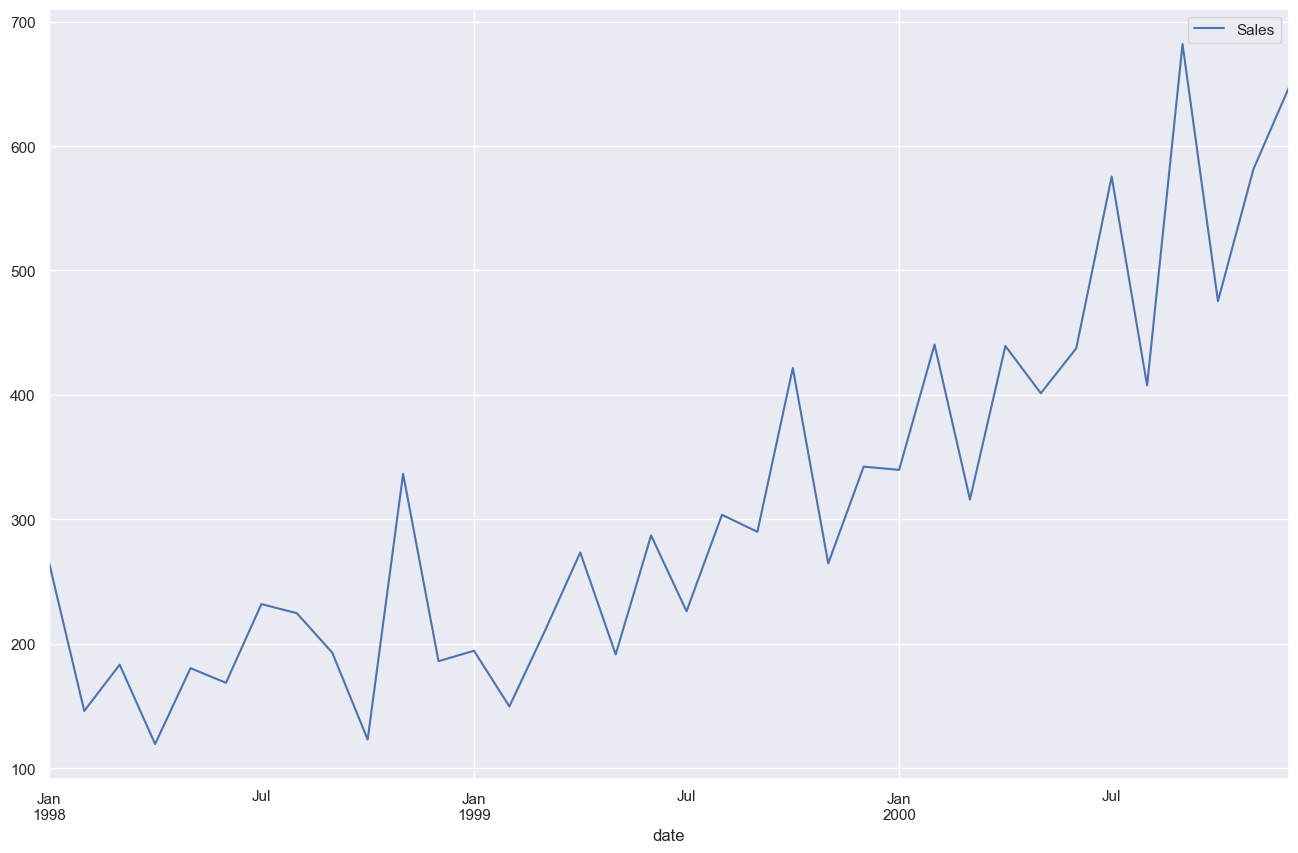

In [16]:
series = pd.read_csv('shampoo.csv', header=0)
series["Year"] = [1998] * 12 + [1999] * 12 + [2000] * 12
series["Month"] = list(range(1,13)) * 3
series["Date"] = series["Month"].apply(str) + "-" + series["Year"].apply(str)
series['date']  = pd.to_datetime(series["Date"])
series = series[["date","Sales"]]
series.set_index(['date'],inplace = True)

import seaborn; seaborn.set()
series.plot(figsize = (16,10))
plt.savefig('shampoo.png')

#### Este set de datos representa la venta de shampoo a lo largo de los años. Como se puede observar en la gráfica, a medida que pasan los años, las ventas de shampoo también crecen. Esto tiene sentido pues mientras más gente nazca, más personas van a ir necesitando shampoo. Sin embargo, no se puede ver una estacionalidad clara en las subidas o bajas de ventas. Esto puede darse debido a que el shampoo es algo que se compra muy a menudo y por lo tanto, no se crean lugares donde las personas por distintas razones salgan a comprar shampoo específicamente en esa epoca. 


## 2. Promedios

Tamaño Entrenamiento 29
Tamaño Prueba 7
Encontrando la mejor solución para promedio
 > Modelo[1, 'promedio'] 161.300
 > Modelo[2, 'promedio'] 113.150
 > Modelo[3, 'promedio'] 111.511
 > Modelo[4, 'promedio'] 121.934
 > Modelo[5, 'promedio'] 119.478
 > Modelo[6, 'promedio'] 132.057
 > Modelo[7, 'promedio'] 137.134
 > Modelo[8, 'promedio'] 146.066
 > Modelo[9, 'promedio'] 151.569
 > Modelo[10, 'promedio'] 159.667
 > Modelo[11, 'promedio'] 164.961
 > Modelo[12, 'promedio'] 173.237
 > Modelo[13, 'promedio'] 179.891
 > Modelo[14, 'promedio'] 186.921
 > Modelo[15, 'promedio'] 193.332
 > Modelo[16, 'promedio'] 201.528
 > Modelo[17, 'promedio'] 208.897
 > Modelo[18, 'promedio'] 215.911
 > Modelo[19, 'promedio'] 222.645
 > Modelo[20, 'promedio'] 227.932
 > Modelo[21, 'promedio'] 234.600
 > Modelo[22, 'promedio'] 239.283
 > Modelo[23, 'promedio'] 244.351
 > Modelo[24, 'promedio'] 248.418
 > Modelo[25, 'promedio'] 252.199
 > Modelo[26, 'promedio'] 256.852
 > Modelo[27, 'promedio'] 261.163
 > Mode

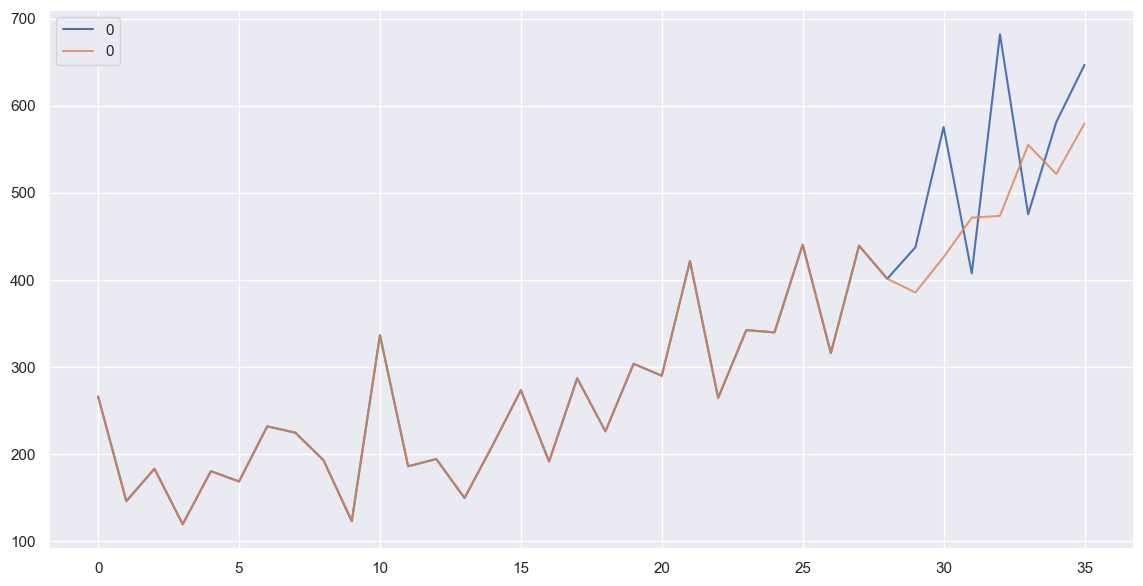

In [17]:
series = pd.read_csv('shampoo.csv', header = 0, index_col = 0)
nombre = "shampoo"
encontrar_mejor_solucion(series, nombre, metodo = "promedio")


## 3. Sarima


In [18]:
def prediccion_sarima(historia, config):
    orden, orden_estacional, tendencia = config
    # definir el modelo
    modelo = SARIMAX(historia, order = orden, seasonal_order = orden_estacional, trend = tendencia,
      enforce_stationarity = False, enforce_invertibility = False)
    # ajustar el model con los datos
    modelo_ajustado = modelo.fit(disp = False)
    # hacer la predicción de un paso
    yhat = modelo_ajustado.predict(len(historia), len(historia))
    return yhat[0]

def config_sarima(estacional = [0]):
    modelos = []
    # definir las listas de configuración
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct'] 
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = estacional
    # crear instancias de configuración
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    modelos.append(cfg)
    return modelos

Tamaño Entrenamiento 29
Tamaño Prueba 7
Encontrando la mejor solución para sarima
 > Modelo[(0, 0, 0), (0, 0, 0, 0), 'n'] 552.408
 > Modelo[(0, 0, 0), (0, 0, 0, 0), 'c'] 279.229
 > Modelo[(0, 0, 0), (0, 0, 0, 0), 't'] 94.526
 > Modelo[(0, 0, 0), (0, 0, 0, 0), 'ct'] 124.959
 > Modelo[(0, 0, 1), (0, 0, 0, 0), 'n'] 370.719
 > Modelo[(0, 0, 1), (0, 0, 0, 0), 'c'] 233.165
 > Modelo[(0, 0, 1), (0, 0, 0, 0), 't'] 100.883
 > Modelo[(0, 0, 1), (0, 0, 0, 0), 'ct'] 125.856
 > Modelo[(0, 0, 2), (0, 0, 0, 0), 'n'] 315.385
 > Modelo[(0, 0, 2), (0, 0, 0, 0), 'c'] 180.964
 > Modelo[(0, 0, 2), (0, 0, 0, 0), 't'] 87.246
 > Modelo[(0, 0, 2), (0, 0, 0, 0), 'ct'] 110.308
 > Modelo[(0, 1, 0), (0, 0, 0, 0), 'n'] 161.300
 > Modelo[(0, 1, 0), (0, 0, 0, 0), 'c'] 161.716
 > Modelo[(0, 1, 0), (0, 0, 0, 0), 't'] 165.520
 > Modelo[(0, 1, 0), (0, 0, 0, 0), 'ct'] 168.712
 > Modelo[(0, 1, 1), (0, 0, 0, 0), 'n'] 126.183
 > Modelo[(0, 1, 1), (0, 0, 0, 0), 'c'] 121.781
 > Modelo[(0, 1, 1), (0, 0, 0, 0), 't'] 95.552
 > Mo

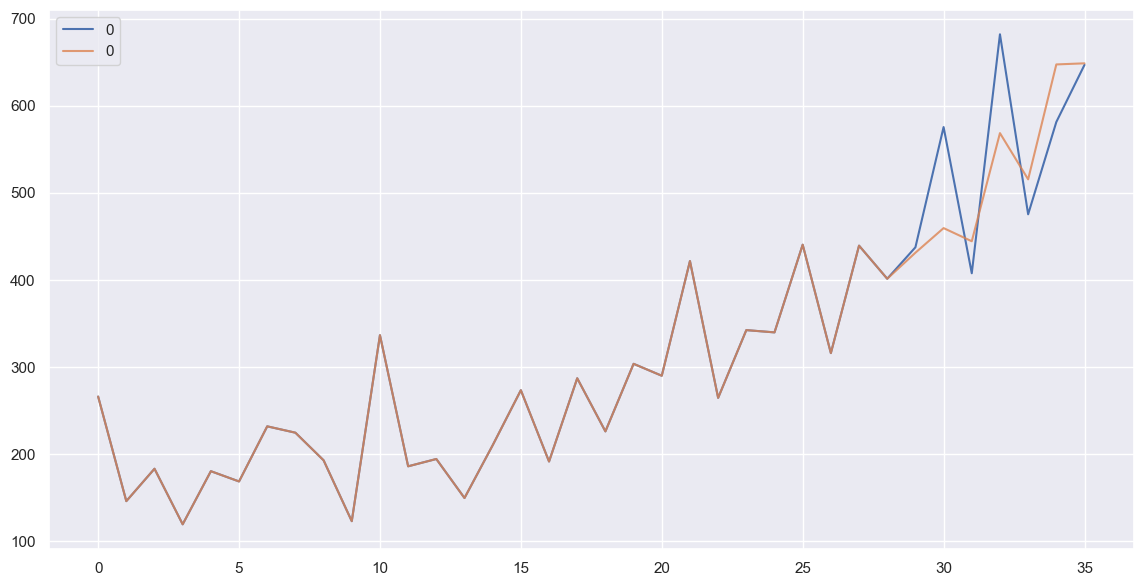

In [19]:
series = pd.read_csv('shampoo.csv', header = 0, index_col = 0)
nombre = "shampoo"
encontrar_mejor_solucion(series, nombre, metodo = "sarima")

## 4. Alisamiento exponencial

/var/folders/8f/4tqfct110qxbk9qrh28g1lpr0000gn/T/ipykernel_8551/2904584695.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  series['date']  = pd.to_datetime(series["Date"])
/Users/priscillagonzalez/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/priscillagonzalez/Library/Python/3.9/lib/python/site-packages/pandas/util/_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/Users/priscillagonzalez/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_

MSE para Alisamiento Exponencial Simple: 8698.86
RMSE para Alisamiento Exponencial Simple: 93.27
MSE para Alisamiento Exponencial Doble: 4280.03
RMSE para Alisamiento Exponencial Doble: 65.42


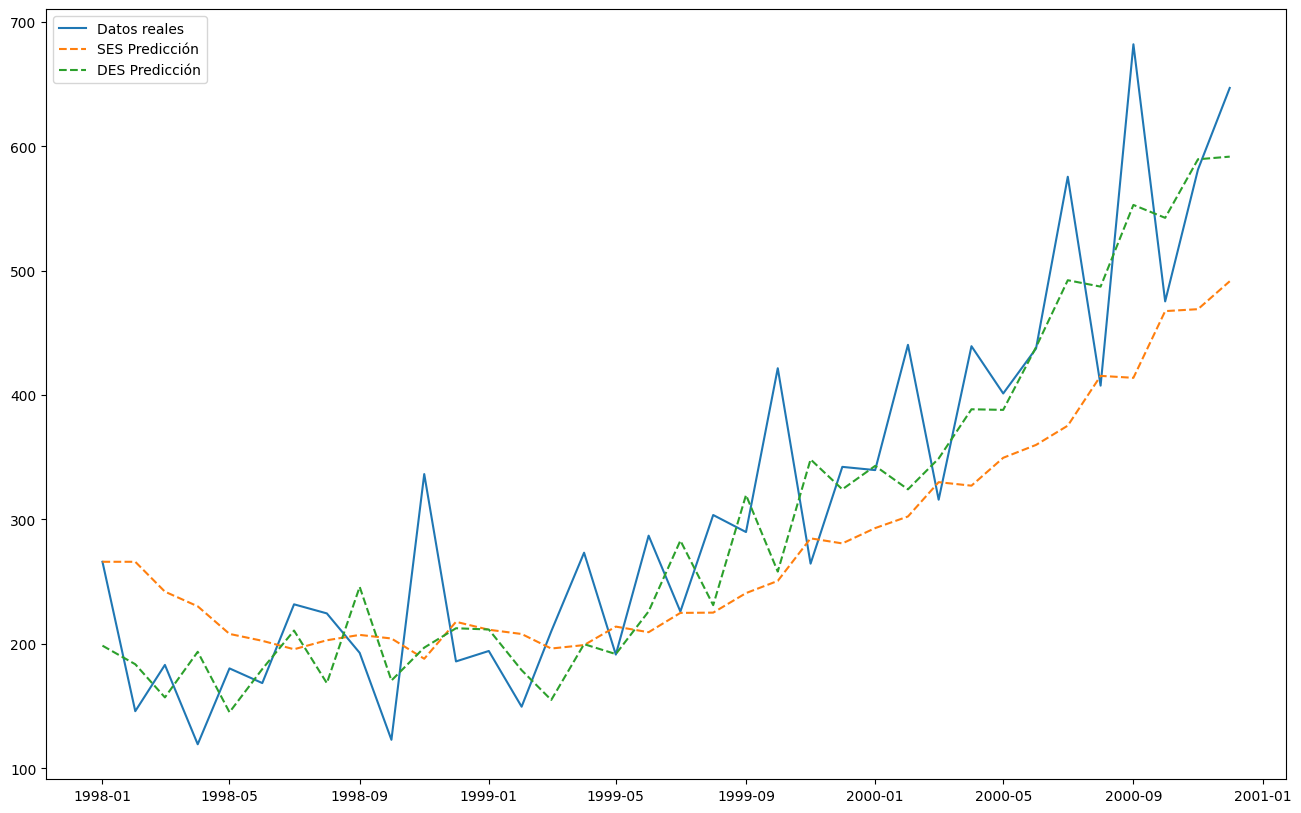

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import numpy as np

# Cargar los datos y configurar el índice
series = pd.read_csv('shampoo.csv', header=0)
series["Year"] = [1998] * 12 + [1999] * 12 + [2000] * 12
series["Month"] = list(range(1,13)) * 3
series["Date"] = series["Month"].apply(str) + "-" + series["Year"].apply(str)
series['date']  = pd.to_datetime(series["Date"])
series = series[["date","Sales"]]
series.set_index(['date'],inplace = True)

# Alisamiento exponencial simple
ses_model = SimpleExpSmoothing(series['Sales']).fit(smoothing_level=0.2)
ses_pred = ses_model.fittedvalues

# Alisamiento exponencial doble
des_model = ExponentialSmoothing(series['Sales'], trend='add', seasonal='add', seasonal_periods=12).fit()
des_pred = des_model.fittedvalues

# Calcular MSE y RMSE para alisamiento exponencial simple
mse_ses = mean_squared_error(series['Sales'], ses_pred)
rmse_ses = np.sqrt(mse_ses)

# Calcular MSE y RMSE para alisamiento exponencial doble
mse_des = mean_squared_error(series['Sales'], des_pred)
rmse_des = np.sqrt(mse_des)

# Graficar los resultados
plt.figure(figsize=(16, 10))
plt.plot(series['Sales'], label='Datos reales')
plt.plot(ses_pred, label='SES Predicción', linestyle='--')
plt.plot(des_pred, label='DES Predicción', linestyle='--')
plt.legend()
plt.savefig('./imagenes/shampoo_alisamiento.png')

print(f'MSE para Alisamiento Exponencial Simple: {mse_ses:.2f}')
print(f'RMSE para Alisamiento Exponencial Simple: {rmse_ses:.2f}')

print(f'MSE para Alisamiento Exponencial Doble: {mse_des:.2f}')
print(f'RMSE para Alisamiento Exponencial Doble: {rmse_des:.2f}')


## 5. Prophet

In [23]:
def prediccion_prophet(series):
    series.head()
    modelo = Prophet(mcmc_samples = 500, seasonality_mode = 'multiplicative').fit(series);
    futuro = modelo.make_future_dataframe(periods = 1,freq = 'M')
    predicciones = modelo.predict(futuro)
    return predicciones.iloc[-1]["yhat"]

In [24]:
def validacion_al_frente(datos, n_entreno, cfg):
    predicciones = []
    # dividir el conjunto de datos
    entreno, prueba = division_entreno_prueba(datos, n_entreno)
    # grabar la historia con el conjunto de datos de entrenamiento
    historia = entreno
    # pasar por cada incremento de tiempo en el conjunto de prueba
    for i in range(len(prueba)):
        # ajustar el modelo a los datos y predecir los datos históricos
        yhat = prediccion_prophet(historia)
        # agregar el dato predicho en la lista de preducciones
        predicciones.append(yhat)
        # agregar la observación a la historia para la siguiente iteración
        historia.append(pd.DataFrame(prueba.iloc[i]))
    # estimar el error de las predicciones
    error = medir_rmse(prueba["y"], predicciones)
    return [error, predicciones]

In [25]:
def evaluar_modelo(datos, n_entreno, metodo, cfg, debug = False):
    resultado = None
    predicciones = None
    # convertir config a una llave
    llave = str(cfg)
    resultado, predicciones = validacion_al_frente(datos, n_entreno, metodo, cfg)
    if resultado is not None:
        print(f' > Modelo[{llave}] {resultado:.3f}')
    return (llave, resultado, predicciones)

In [26]:
def buscar_mejor_solucion(series, nombre, metodo = "prophet"):    
    datos = series

    resultados = []
    # división de datos
    n_entreno = int(len(datos)*0.8) # porcentaje usado para entrenar
    long_max = len(datos) - n_entreno
    print(f"Tamaño entreno {n_entreno} ")
    print(f"Tamaño prueba {long_max}")
    lista_cfg = [1]
    
    resultados = [evaluar_modelo(datos, n_entreno, metodo, cfg) for cfg in lista_cfg]
    
    # ordenar configs por error, ascendente
    resultados.sort(key=lambda tup: tup[1])


    print('terminado')
    # listar las tres configuraciones mejores
    for cfg, error, predicciones in resultados[:3]:
        print(cfg, error)

    
    #desplegar
    entreno, prueba = division_entreno_prueba(datos,n_entreno)
    prediccion = pd.DataFrame(list(entreno["y"]) + resultados[0][2])
    
    #####
    datos.set_index(['ds'],inplace=True)
    #prediccion.set_index(['ds'],inplace = True)
    prediccion.index = datos.index


    ax = pd.DataFrame(datos).plot(label="Original") # datos originales
    prediccion.plot(ax=ax, alpha=.7, figsize=(14,7))
    plt.savefig(f"{nombre}_{metodo}.png")
    plt.show()
    return [datos,prediccion]

In [27]:
def evaluar_prediccion(series, frecuencia = "M"):
    datos = series
    n_entreno = int(len(datos) * 0.8) # porcentaje usado para entreno
    long_max = len(datos) - n_entreno
    print(f"Tamaño entreno {n_entreno} ")
    print(f"Tamaño prueba {long_max} ")
    lista_cfg = [1]
    entreno, prueba = division_entreno_prueba(datos, n_entreno)
    modelo = Prophet(mcmc_samples = 500, seasonality_mode = 'multiplicative').fit(series);
    futuro = modelo.make_future_dataframe(periods = len(prueba),freq = frecuencia)
    predicciones = modelo.predict(futuro)
    modelo.plot(predicciones)
    rmse = medir_rmse(predicciones.iloc[len(entreno):len(series)]["yhat"], prueba["y"])
    print(f"RMSE: {rmse}")

Tamaño entreno 28 
Tamaño prueba 8 


04:28:32 - cmdstanpy - INFO - CmdStan start processing




































































































































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


04:28:36 - cmdstanpy - INFO - CmdStan done processing.
04:28:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True


RMSE: 155.80429917748117


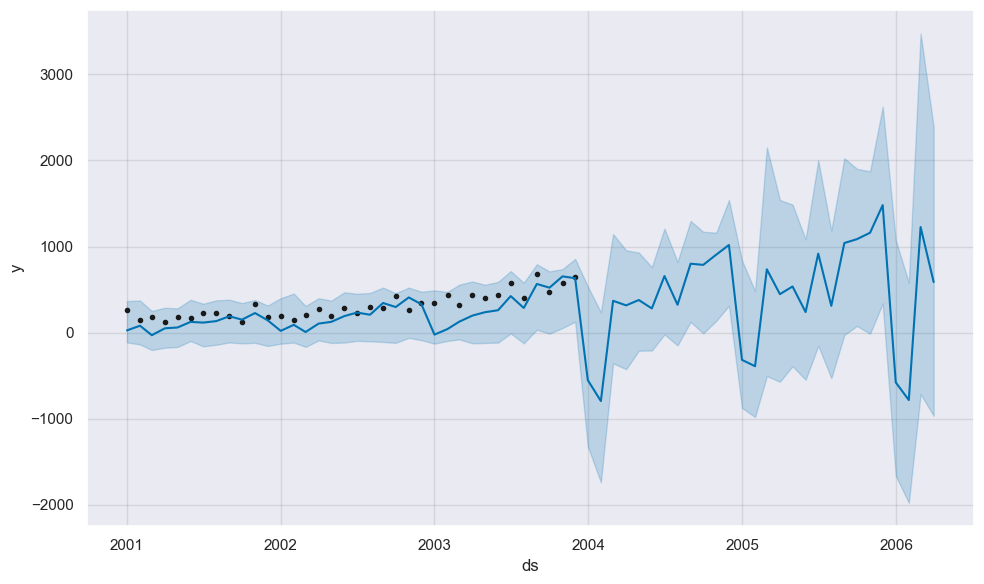

In [28]:
series = pd.read_csv('shampoo.csv', header=0)
series['ds']  = series['Month'].apply(lambda x: parse_date(x))
series[['y']] = series[['Sales']].astype(float)
series = series[["ds","y"]]
evaluar_prediccion(series)

## 6. Red Neuronal

In [29]:
import tensorflow as tf


In [30]:
# split a univariate dataset into train/test sets
def division_entreno_prueba(datos, n_prueba):
    return datos[:-n_prueba], datos[-n_prueba:]

In [31]:
def series_a_supervisado(datos, n_entrada, n_salida = 1):
	df = DataFrame(datos)
	cols = []
	# secuencia de entrada (t-n, ... t-1)
	for i in range(n_entrada, 0, -1):
		cols.append(df.shift(i))
	# secuencia predicha (t, t+1, ... t+n)
	for i in range(0, n_salida):
		cols.append(df.shift(-i))
	# juntarlo todo
	agg = concat(cols, axis = 1)
	# botar columnas con valores NaN
	agg.dropna(inplace = True)
	return agg.values

In [32]:
def evaluacion_iter(datos, config, n_prueba, n_repeticiones = 5):
	# ajustar y evaluar el modelo n veces
    resultados = []
    predicciones = []
    for _ in range(n_repeticiones):
        resultados_temp, predicciones_temp = validacion_al_frente(datos, n_prueba, config)
        resultados.append(resultados_temp)
        predicciones.append(predicciones_temp)
    return [resultados, predicciones]

In [33]:
def ajustar_modelo(entreno, config):
	# desempacar la configuración
	n_entrada, n_nodos, n_epocas, n_tandas = config
    #[24, 500, 100, 100]
    # preparar los datos
	datos = series_a_supervisado(entreno, n_entrada)
	entreno_x, entreno_y = datos[:, :-1], datos[:, -1]
	# definir el modelo
	modelo = tf.keras.Sequential()
	modelo.add(tf.keras.layers.Dense(n_nodos, activation='relu', input_dim = n_entrada))
	modelo.add(tf.keras.layers.Dense(1))
	modelo.compile(loss='mse', optimizer='adam')
	# ajustar
	modelo.fit(entreno_x, entreno_y, epochs = n_epocas, batch_size = n_tandas, verbose = 0)
	return modelo

In [34]:
def prediccion_modelo(modelo, historia, config):
	# desempacar la configuración
	n_entrada, _, _, _ = config
	# preparar los datos
	x_entrada = array(historia[-n_entrada:]).reshape(1, n_entrada)
	# predecir
	yhat = modelo.predict(x_entrada, verbose = 0)
	return yhat[0]

In [35]:
def validacion_al_frente(datos, n_prueba, cfg):
    predicciones = []
    # dividir el conjunto de datos
    entreno, prueba = division_entreno_prueba(datos, n_prueba)
    # ajustar el modelo
    modelo = ajustar_modelo(entreno, cfg)
    # grabar la historia con el conjunto de datos de entrenamiento
    historia = [x for x in entreno]
    # pasar por cada incremento de tiempo en el conjunto de prueba
    for i in range(len(prueba)):
        # ajustar el modelo a los datos y predecir los datos históricos
        yhat = prediccion_modelo(modelo, historia, cfg)
        # agregar el dato predicho en la lista de preducciones
        predicciones.append(yhat)
        # agregar la observación a la historia para la siguiente iteración
        historia.append(prueba[i])
    # estimar el error de las predicciones
    error = medir_rmse(prueba, predicciones)
    print(f' > {error:.3f}')
    return [error, predicciones]

In [36]:
def resumir_resultados(nombre, resultados):
	# imprimir un resúmen
	media_result, std_result = mean(resultados), std(resultados)
	print(f'{nombre}: {media_result:.3f} RMSE (+/- {std_result:.3f})')
	# gráficas de caja y bigotes
	pyplot.boxplot(resultados)
	pyplot.show()

In [37]:
def buscar_mejor_solucion(series, nombre, metodo = "red neuronal"):
    datos = series.values
    n_prueba = int(len(datos)*0.2) # porcentaje utilizado para prueba
    config = [24, 500, 100, 100]
    resultados, predicciones = evaluacion_iter(datos, config, n_prueba)
    resumir_resultados('mlp', resultados)
    plt.savefig("resultados_{nombre}_{metodo}.png")
    plt.show()
    entreno, prueba = division_entreno_prueba(datos,n_prueba)
    prediccion = pd.DataFrame(list(entreno.flatten()) + np.array(predicciones[0]).flatten().tolist())
    ax = pd.DataFrame(datos).plot(label="Original") # datos originales
    prediccion.plot(ax=ax, alpha=.7, figsize=(14,7))
    plt.savefig("pred_{nombre}_{metodo}.png")
    plt.show()

 > 114.521
 > 105.431
 > 96.815
 > 109.596
 > 109.759
mlp: 107.224 RMSE (+/- 5.947)


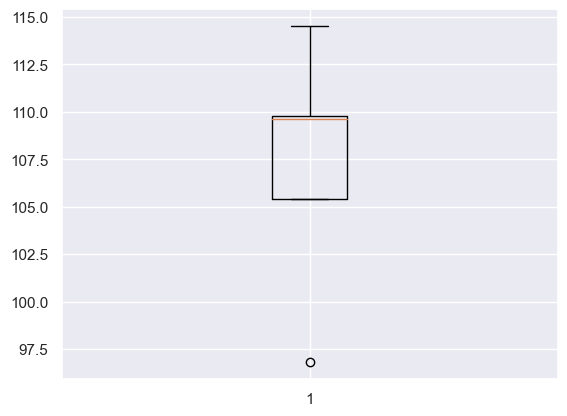

<Figure size 640x480 with 0 Axes>

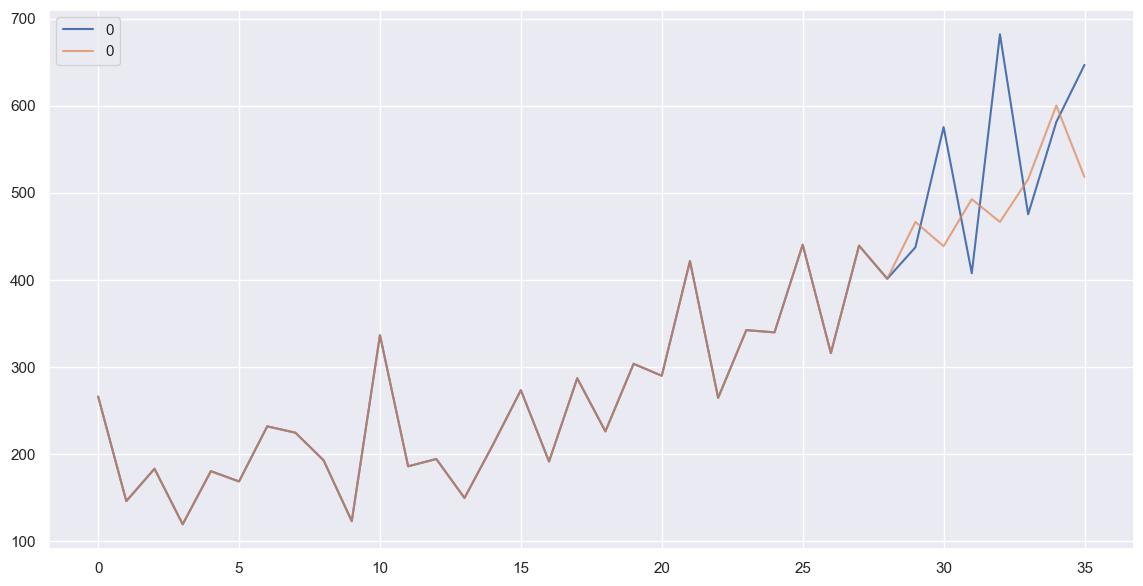

In [38]:
series = pd.read_csv('shampoo.csv', header=0,index_col=0)
buscar_mejor_solucion(series,"shampoo")

## 7. Comparación y evaluación

#### Al obtener el RSME Y MSE de cada uno de los modelos, siendo los siguientes: 
#### - MSE para Alisamiento Exponencial Simple: 8698.86
#### - RMSE para Alisamiento Exponencial Simple: 93.27
#### - MSE para Alisamiento Exponencial Doble: 4280.03
#### -RMSE para Alisamiento Exponencial Doble: 65.42
#### - RMSE Prophet: 155.80429917748117
#### - RMSE RNN: 5.947
#### Se puede observar que claramente el modelo que tuvo un mejor desempeño con dichos datos fue la RNN. Esto puede deberse a la cantidad de datos que se están manejando. Además, puede deberse a que los hiperparámetros para la RNN se han ajustado y seleccionado de manera correcta.